In [1]:
#using Pkg
#Pkg.add("Images")
#Pkg.add("MAT")
#Pkg.add("ImageIO")
#Pkg.add("QuartzImageIO")
#Pkg.add("ImageMagick")

using MAT
using Plots
using Images
using Distributed
CPU_CORES = 4 # number of cores on the machine
addprocs(CPU_CORES - 1);
@everywhere using LinearAlgebra

using Distributed

pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

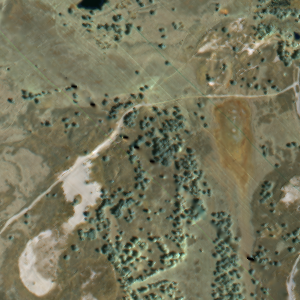

In [49]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

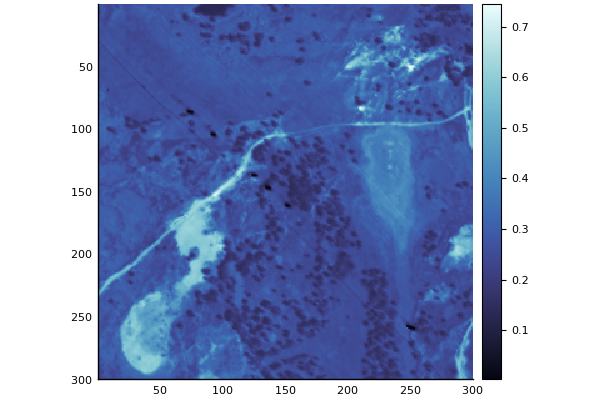

In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

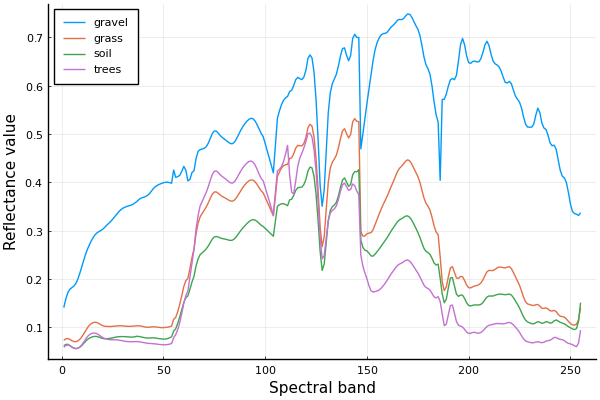

In [4]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [6]:
#img_test = img[1:10,1:10,:]; # use a small crop of the image first
#img_test = copy(img);

## Introduction :
Dans le contexte de *l'hyperspectral image unmixing*, étant donné la matrice des *endmembers* (estimée au préalable) ainsi que les données spectrales d'une image nous allons tenter d'estimer la matrice d'abondance relative. Ce problème s'exprime sous la forme de la minimisation d'une fonction avec le respect de deux contraintes pour la matrice d'abondance :
* Non négativité des coefficients (non sens physique)
* Somme de chaque colonne égale à 1

Ce problème est qualifié **d'embarrasingly**, c'est à dire que nous pouvons diviser la tâche à effectuer en sous tâches indépendantes puis assembler chaque résultat.  

Dans ce qui suit, nous allons étudier l'intérêt (en terme de temps d'exécution) de la programmation en parallèle. Dans un premier temps nous nous focaliserons sur le respect de la contrainte de non négativité. Pour cela nous allons appliquer l'algorithme de descente du gradient, en projetant le résultat sur l'espace des contraintes (i.e mettre à 0 les valeurs négatives). Puis grâce à des librairies d'optimisation nous incluerons la contrainte de somme à un qui nous donnera un résultat plus cohérent pour la matrice d'abondance.  

Enfin il faut noter que les calculs en parallèle ont été effectués sur une machine possédant **4** coeurs 

## Optimisation avec projected gradient descent (respect de la contrainte de non négativité)

In [2]:
# img is a 3D-array, this function return a 2D-array
# each line corresponds to a wavelength
# each column stands for a pixel
function getDataMatrix(img)
    (nx,ny,l) = size(img)
    X = zeros(l,nx*ny)
    for i=1:l
        X[i,:] = img[:,:,i][:]
    end
    return X
end

# Compute the abundance matrix given pixels, endmember matrix and function and its gradient to minimize it
# We use the macro @everywhere to make the function available for all workers during a parallelized implementation
@everywhere function gradientDescentANC(X,S,f,∇f;prec=1.e-3,verbose=false)
    n,p = size(X,2),size(S,2)
    init = zeros(p,n)
    #stepsize = opnorm(S'*S)
    stepsize,prec,δ,n_iter,max_iter = .001, prec, 1, 0, 10000
    pt = init
    while (δ > prec) & (n_iter < max_iter)
        n_iter += 1
        old = pt
        pt = pt - stepsize*∇f(pt,X,S)
        δ = tr((old - pt)'*(old-pt))
        pt = map(x -> x < 0 ? 0 : x,pt)
        #n_iter%100 == 0 ? println("iteration n°$(n_iter), value = $(f(pt))") : nothing
    end
    if verbose & (n_iter==max_iter)
        println("maximum iteration reached in gradient descent")
    end
    return pt
end

# Compute the abundance matrix column by column (gradient is computed for each pixel not anymore globally)
function gradientDescentANC_pixelwise(X,S,f,∇f;prec=1.e-3)
    abundance = zeros(size(S,2),size(X,2))
    for i in 1:size(X,2)
        col_abundance = gradientDescentANC(X[:,i],S,f,∇f,prec=prec)
        abundance[:,i] = col_abundance
    end
    return abundance
end

# Compute the abundance matrix in parallel using 4 cores
function gradientDescentANC_parallel(X,S,f,∇f;prec=1.e-3)
    abundance = hcat(pmap(x->gradientDescentANC(x,S,f,∇f,prec=prec),[X[:,x] for x in 1:size(X,2)])...)
    return abundance
end
    

# Given a range and a function, compute the execution time of the function for each size in sizes
function getTimeExecution(sizes,method)
    times = []
    for i in sizes
        img_test = img[1:i,1:i,:]
        X = getDataMatrix(img_test)
        time = @elapsed method(X)
        append!(times,time)
    end
    return sizes,times
end

# Plot the results of the previous function
function plotExecutionTime(sizes,times,methodLabel;title="number of pixels")
    p = plot(sizes.^2,times,label=methodLabel)
    xlabel!("pixels")
    ylabel!("number of seconds")
    title!("Execution time according to $(title)")
    return p
end
    
# setting variables
S = sources
@everywhere f(A,X,S) = tr((X-S*A)'*(X-S*A))
@everywhere ∇f(A,X,S) = 2*S'*(S*A - X);

## Implémentation global

In [30]:
sizes1,times1 = getTimeExecution(5:50,X->gradientDescentANC(X,S,f,∇f));

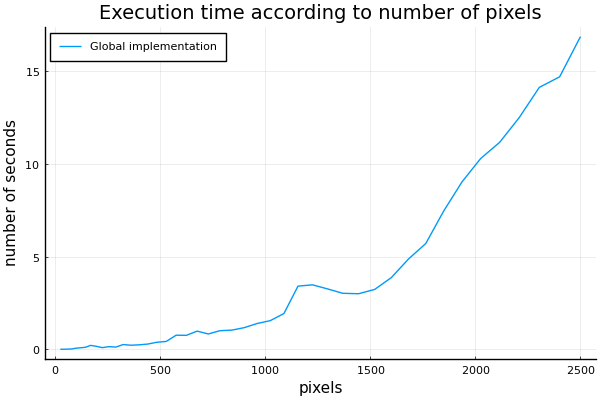

In [31]:
plotExecutionTime(sizes1,times1,"Global implementation")

## Implémentation pixel par pixel

In [56]:
# pixelwise implementation using a for loop
sizes2,times2 = getTimeExecution(5:300,X->gradientDescentANC_pixelwise(X,S,f,∇f));

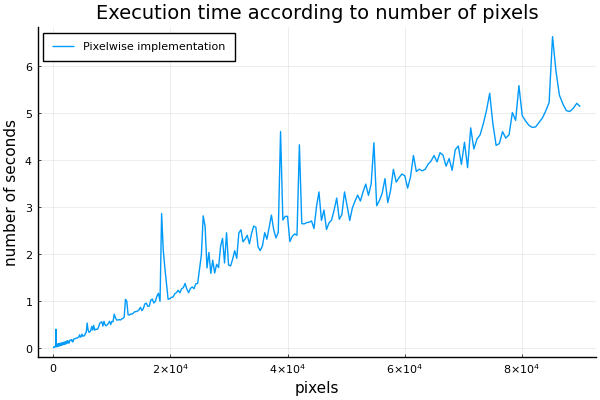

In [57]:
plotExecutionTime(sizes2,times2,"Pixelwise implementation")

## Version parallélisée
- [x] parallélisation sur chaque pixel

In [3]:
# Plot time execution function of size of image
sizes3,times3 = getTimeExecution(5:300,X->gradientDescentANC_parallel(X,S,f,∇f))

(5:300, Any[6.856360081, 0.039979793, 0.037891991, 0.045710205, 0.048313183, 0.05573256, 0.059959862, 0.06829631, 0.164846989, 0.087386236  …  23.061251208, 23.354716401, 25.254727435, 22.436619874, 23.708439199, 22.152854033, 23.035566198, 23.022463792, 25.31777519, 22.817099763])

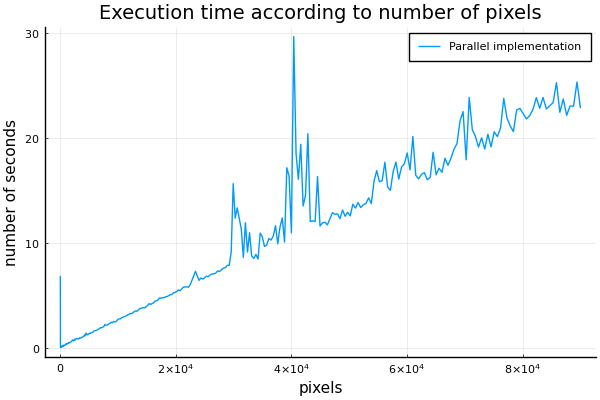

In [4]:
plotExecutionTime(sizes3,times3,"Parallel implementation")

## Comparaison des méthodes

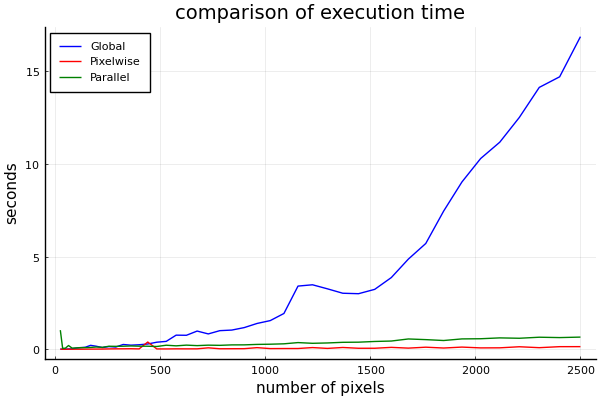

In [72]:
n = length(times1)
plot(sizes1.^2,[times1,times2[1:n],times3[1:n]],label=["Global" "Pixelwise" "Parallel"],c=["blue" "red" "green"])
title!("comparison of execution time")
xlabel!("number of pixels")
ylabel!("seconds")

### Description et Interpretation
Dans un premier temps nous avons estimé la matrice d'abondance avec un algorithme du gradient, adapté pour respécter la contrainte de non négativité. Nous avons implémenté trois versions différentes :
1. Calcul du gradient de manière globale sur tous les pixels
1. Calcul du gradient pixel par pixel (ce qui revient à construire la matrice d'abondance colonne par colonne)
1. Calcul du gradient en parallèle. Equivalent au calcul pixel par pixel mais sur plusieurs coeurs en même temps.

Plusieurs remarques :
* Au vu de la courbe du temps d'éxecution pour la méthode globale, il n'est pas envisageable d'utiliser cette méthode pour effectuer les calculs sur l'intégralité de l'image.
* La méthode qui consiste à calculer la matrice d'abondance colonne par colonne s'avère très efficace pour réduire le temps de calcul.
* On remarque que la parallélisation est moins efficace que la méthode séquentielle. En effet sur l'ensemble de l'image la méthode séquentielle termine en environ 5s tandis que la méthode parallèle termine en environ 25 secondes. Cela peut s'expliquer par la notion d'**overhead** qui est vraisemblablement élevé à cause de la communication des données d'un processus à l'autre.

## Interpretation de la matrice d'abondance
A présent nous allons interpréter les résultats obtenus pour l'estimation de la matrice d'abondance. En effet chaque colonne représente la proportion des différents matériaux pour le pixel correspondant. Ainsi on peut savoir quel matériau est le plus représentatif d'un pixel. Nous pouvons également définir un seuil au dessus duquel les pixels sont considérés comme purs (un seul matériau).  
Ensuite chaque ligne de la matrice d'abondance représente un matériau donné, on peut ainsi isoler chaque matériau grâce à la matrice d'abondance.

In [7]:
img_test = copy(img);
X = getDataMatrix(img_test)
abundance_matrix = hcat(pmap(x->gradientDescentANC(x,S,f,∇f),[X[:,x] for x in 1:size(X,2)])...)

4×90000 Array{Float64,2}:
 0.248578  0.253214  0.249965  0.206023  …  0.17624    0.180142   0.180565
 0.165326  0.16739   0.163256  0.132312     0.107547   0.108881   0.109522
 0.131255  0.13284   0.129542  0.105085     0.0854434  0.0865052  0.0870406
 0.14231   0.143135  0.137775  0.110699     0.0873676  0.0872771  0.0879218

In [46]:
# représente l'image de chaque matériau
function plotAbundance(A)
    heatmaps = []
    for i in 1:size(A,1)
        h = heatmap(reshape(A[i,:],(300,300)),yflip=true,aspect_ratio=1,c=:ice)
        push!(heatmaps,h)
    end
    plot(heatmaps...,layout=size(A,1))
end

plotAbundance (generic function with 1 method)

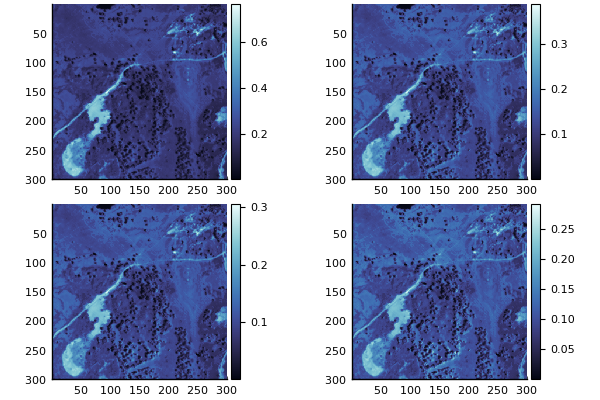

In [114]:
plotAbundance(abundance_matrix)

In [71]:
max_abundance = hcat(map(col->maximum(col)*(col.==maximum(col)),eachcol(abundance_matrix))...)
map(sum,eachrow(max_abundance))

4-element Array{Float64,1}:
 19161.613945623918
     0.0
     0.0
     0.0

Ici nous avons représenté l'image en fonction des coefficients d'abondance pour chaque matériaux. Cependant nous ne distinguons pas un matériaux par image mais bien chaque matériaux (avec une intensité plus ou moins élevée).  
Ceci est sans doute dû au non respect de la somme à 1 des abondances pour un pixel.  
De plus on remarque (calcul dans la cellule précédente) que le matériau avec le plus grand coefficient d'abondance est à chaque fois le premier. Ainsi notre matrice d'abondance ne reflète pas la présence de zones avec une densité de matériau élevée.

## Optimisation avec le respect des deux contraintes

In [5]:
@everywhere using JuMP,ECOS

In [6]:
# Pixelwise implementation with respect of the two constraints (sum to one and non negativity)
@everywhere function abundanceASC(X,S,f,∇f;verbose=false)
    opt = ()->ECOS.Optimizer(verbose=false)
    abundance = zeros(size(S,2),size(X,2))
    for i in 1:size(abundance,2)
        x = X[:,i]
        m = Model(with_optimizer(opt))
        @variable(m, 0 <= A[1:size(S,2),1])
        @objective(m, Min, f(A,x,S))
        @constraint(m,sum(A[:,1])==1)
        optimize!(m)
        abundance[:,i] = value.(A)
        if verbose & (i%1000 == 0)
            println("$(i) columns computed")
        end
    end
    return abundance
end

function abundanceASC_parallele(X,S,f,∇f)
    abundance = hcat(pmap(x->abundanceASC(x,S,f,∇f),[X[:,x] for x in 1:size(X,2)])...)
    return abundance
end

abundanceASC_parallele (generic function with 1 method)

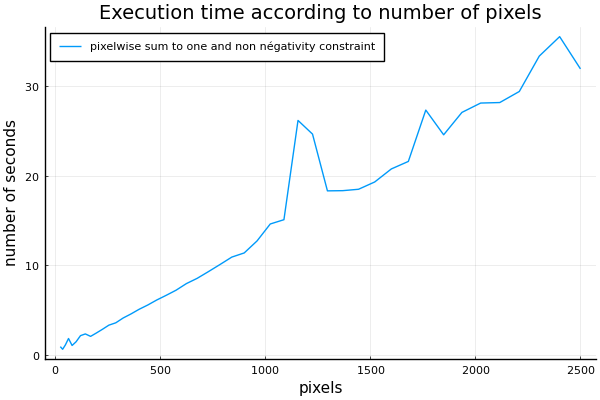

In [72]:
sizes4,times4 = getTimeExecution(5:50,X->abundanceASC(X,S,f,∇f))
plotExecutionTime(sizes4,times4,"pixelwise sum to one and non négativity constraint")

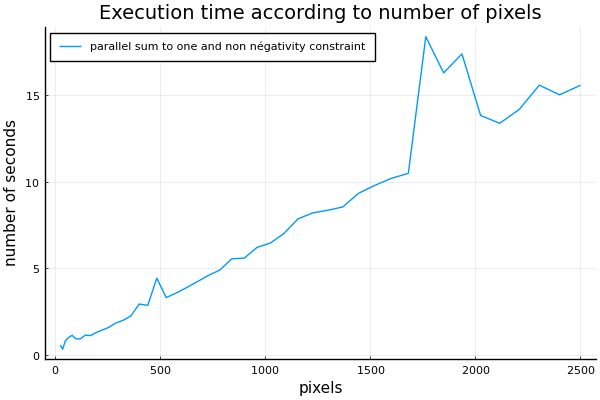

In [73]:
sizes5,times5 = getTimeExecution(5:50,X->abundanceASC_parallele(X,S,f,∇f))
plotExecutionTime(sizes5,times5,"parallel sum to one and non négativity constraint")

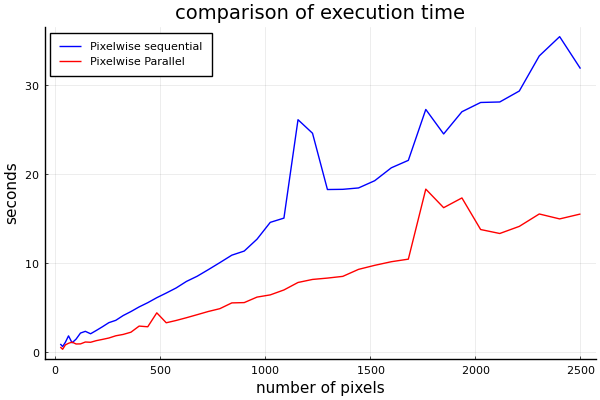

In [74]:
plot(sizes4.^2,[times4,times5],label=["Pixelwise sequential" "Pixelwise Parallel"],c=["blue" "red"])
title!("comparison of execution time")
xlabel!("number of pixels")
ylabel!("seconds")

Nous remarquons que le temps d'exécution de la version parallèle est inférieur à la version séquentielle. Ici le calcul de chaque colonne de la matrice d'abondance est plus complexe comparé à la fois où nous ne respections uniquement la contrainte de non négativité. Ainsi le fait de paralléliser l'exécution des calculs permet ici un gain de temps.

In [7]:
img_test = img[1:300,1:300,:]
X = getDataMatrix(img_test)
time_s = @elapsed abundanceASC(X,S,f,∇f)
time_p = @elapsed abundanceASC_parallele(X,S,f,∇f)
println("Time execution sequentiel : $(time_s) s\nTime execution parallel : $(time_p)")

Time execution sequentiel : 1352.657165162 s
Time execution parallel : 693.004464021


Sur l'ensemble de l'image, l'algorithme effectué en parallèle est deux fois plus rapide que celui exécuté en séquentiel. Ce gain de temps est interessant, cependant on aurait pu s'attendre à un facteur 4 et non 2 dû aux 4 coeurs de la machine sur laquelle le programme a été exécuté. Encore une fois ceci est dû à l'**overhead** induit par le calcul parallèle.

## Calcul et visualisation de la matrice d'abondance

In [45]:
img_test = img[1:300,1:300,:]
X = getDataMatrix(img_test)
abundance_all_contraints = abundanceASC(X,S,f,∇f,verbose=true)

1000 columns computed
2000 columns computed
3000 columns computed
4000 columns computed
5000 columns computed
6000 columns computed
7000 columns computed
8000 columns computed
9000 columns computed
10000 columns computed
11000 columns computed
12000 columns computed
13000 columns computed
14000 columns computed
15000 columns computed
16000 columns computed
17000 columns computed
18000 columns computed
19000 columns computed
20000 columns computed
21000 columns computed
22000 columns computed
23000 columns computed
24000 columns computed
25000 columns computed
26000 columns computed
27000 columns computed
28000 columns computed
29000 columns computed
30000 columns computed
31000 columns computed
32000 columns computed
33000 columns computed
34000 columns computed
35000 columns computed
36000 columns computed
37000 columns computed
38000 columns computed
39000 columns computed
40000 columns computed
41000 columns computed
42000 columns computed
43000 columns computed
44000 columns comput

4×90000 Array{Float64,2}:
 0.0363138   0.0357185   0.00178903  …  9.74162e-11  7.95815e-8  1.17059e-7
 0.69519     0.765569    0.915402       3.0087e-10   3.88102e-8  5.21141e-8
 1.08945e-9  2.61323e-8  2.06666e-8     1.0          1.0         1.0
 0.268496    0.198713    0.0828091      4.2685e-10   2.04261e-8  2.5479e-8

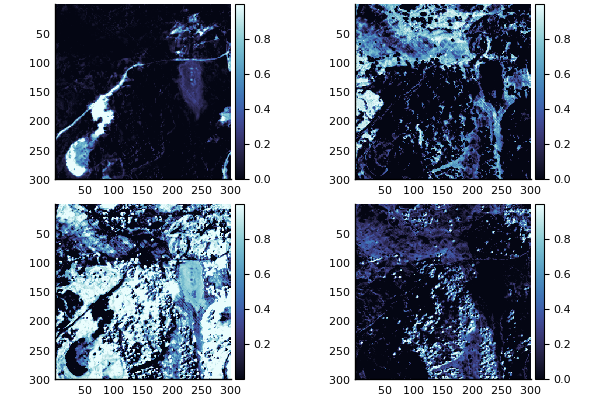

In [47]:
plotAbundance(abundance_all_contraints)

En estimant la matrice d'abondance en respectant cette fois-ci la contraintes de somme à un, nous obtenons des résultats plus interessants. En effet sur la figure ci-dessus nous pouvons voir que chacun des 4 matériaux présents sur l'image a pu être isolé. 

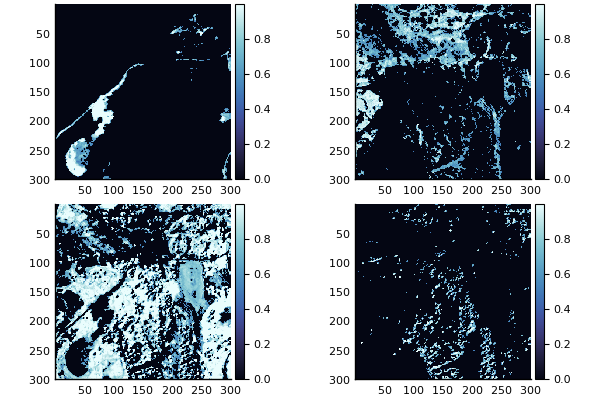

In [81]:
abundance_treshold = abundance_all_contraints.*(abundance_all_contraints .>.5) # Seuil pour avoir les pixels purs
plotAbundance(abundance_treshold)

Ici en seuillant la matrice d'abondance pour obtenir les pixels "purs" on obtient une séparation encore plus nette des matériaux de l'image

## Conclusion
Dans ce travail, nous avons pu estimer la matrice d'abondance correspondant à notre image. Tout d'abord nous avons pu constater qu'il était plus intéressant de calculer cette matrice colonne par colonne. Lors de la résolution avec la prise en compte uniquement de la contrainte de non négativité, il est plus intéressant de ne pas faire appel au calcul en parallèle. En effet à cause de la simplicité des calculs, l'**overhead** de la parallélisation est trop important pour garder un intêret de l'exécution sur 4 coeurs parallèles. Cependant dans le cas ou nous considérons la contrainte de somme à un, nous avons vu que la méthode parallèle était nettement plus efficace que la méthode séquentielle.